## Table of contents
- [Basic data exploration](#Basic-data-exploration)
- [Cross validation of KNN](#Cross-validation-of-KNN)
- [Visualizing accuracy with a confusion matrix](#Visualizing-accuracy-with-a-confusion-matrix)
- [Visualizing the predictions onto projected coordinates](#Visualizing-the-predictions-onto-projected-coordinates)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## Load smartphone activity data and split into training and test sets 

#### Data consists of activity data collected from accelerometers/gyroscopes from the smartphones (worn on the waist) of 20 subjects, the data was labeled based on the activity each subject was doing:
- Walking
- Walking up stairs
- Walking down stairs
- Sitting
- Standing
- Laying

#### The data for each subject contains ~300 data points collected over a period of time.

Data source: http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [4]:
#read in the smartphone-activity data
training_data = pd.read_csv('training_data.csv', header=None)
training_labels = pd.read_csv('training_labels.csv', header=None)
training_subjects = pd.read_csv('training_subjects.csv', header=None)
label_dictionary = {1:'walking', 
                    2:'walking up stairs', 
                    3:'walking down stairs', 
                    4:'sitting', 
                    5:'standing', 
                    6:'laying' }

In [5]:
#randomly split data into test and training sets based on subjects in the study
split_ratio = 0.75
subjects = np.unique(training_subjects.values)
n_subjects = len(subjects)
training_subject_numbers = np.random.choice(subjects, np.round(n_subjects*split_ratio), replace=False)

split_mask = np.in1d(training_subjects[0], training_subject_numbers)
split_training_data = training_data[split_mask]
split_training_labels = training_labels[split_mask]
split_test_data = training_data[~split_mask]
split_test_labels = training_labels[~split_mask]

## Basic data exploration

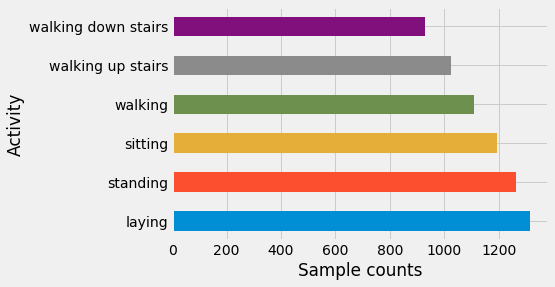

In [6]:
#extract value counts for each category and visualize
fig, ax = plt.subplots()
training_labels.apply(pd.value_counts)\
               .sort_index(axis=1)\
               .rename(label_dictionary, columns = {0:'counts'})\
               .plot(kind='barh', y="counts", ax=ax)
ax.set_xlabel('Sample counts')
ax.set_ylabel('Activity')
ax.legend().set_visible(False)

# Cross validation of KNN

[Back to top](#Table-of-contents)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
neighbors = [1,3,5,10,15,20,25,40, 50]
all_scores=[]
means = []
for n in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(neigh, split_training_data, split_training_labels[0], cv=5)
    all_scores.append(scores)
    means.append(np.mean(scores))

Text(0,0.5,u'Recall')

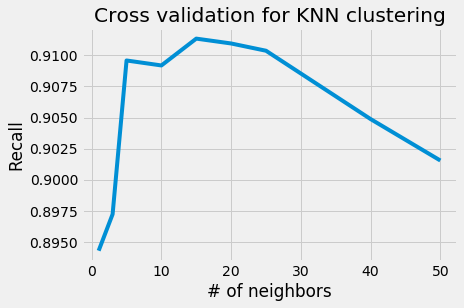

In [6]:
plt.plot(neighbors, means)
plt.title('Cross validation for KNN clustering')
plt.xlabel('# of neighbors')
plt.ylabel('Recall')

## Check accuracy of KNN classifier on test set

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(split_training_data, np.ravel(split_training_labels)) 
KNN_pred = neigh.predict(split_test_data)
accuracy_score(split_test_labels, KNN_pred)

0.89009730967372636

# Visualizing accuracy with a confusion matrix

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    import itertools
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.99  0.    0.    0.    0.    0.  ]
 [ 0.02  0.94  0.04  0.    0.    0.  ]
 [ 0.    0.02  0.98  0.    0.    0.  ]
 [ 0.    0.01  0.    0.72  0.26  0.01]
 [ 0.    0.    0.    0.18  0.82  0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]]


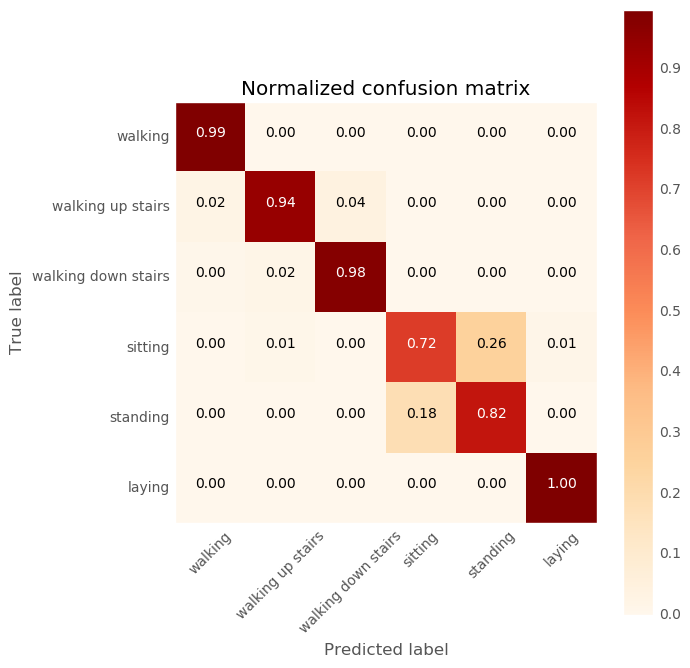

In [36]:
from sklearn.metrics import confusion_matrix

class_names = label_dictionary.values()

# Compute confusion matrix
cnf_matrix = confusion_matrix(split_test_labels, KNN_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
#plt.figure()
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
ax.grid(False)

plt.show()

# Visualizing the predictions onto projected coordinates

In [13]:
#Predictions from KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from bokeh.palettes import Spectral6
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

X = split_test_data
y = np.ravel(split_test_labels)
target_names = label_dictionary.values()

lda = LinearDiscriminantAnalysis()
X_r2 = lda.fit(X, y).transform(X)

p = figure(plot_width=600, plot_height=600)
for label, name, color in zip(range(1,7), target_names, Spectral6):
    label_msk = np.asarray(split_test_labels[0]==label)
    correct_msk = np.asarray(KNN_pred == split_test_labels[0])[label_msk]
    p.scatter(X_r2.T[0][label_msk][correct_msk], X_r2.T[1][label_msk][correct_msk], color=color, alpha=0.8, size=12,
              marker="circle", line_color="black", legend=name)
    p.scatter(X_r2.T[0][label_msk][~correct_msk], X_r2.T[1][label_msk][~correct_msk], color=color, alpha=0.8, size=12,
              marker="circle_x", line_color="black", legend="misclassified " + name)

p.legend.click_policy="hide"
p.xaxis.axis_label = "LD 1"
p.yaxis.axis_label = "LD 2"
p.legend.location = "bottom_center"

output_notebook()
show(p)


Loading BokehJS ...

In [10]:
KNN_pred_training = neigh.predict(split_training_data)
accuracy_score(split_training_labels, KNN_pred_training)

0.96931549960660901